In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio

from astropy import units as u
from astropy.coordinates import SkyCoord

sys.path.append(os.path.expanduser("~")+'/git/Python/user_modules/')
from match_coord import search_around, scatter_plot, match_coord

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
tycho = Table.read('/global/u2/r/rongpu/temp/tycho2-reddest.fits')
print(len(tycho))

5126


In [4]:
tycho[:1]

tyc1,tyc2,tyc3,ra,dec,mean_ra,mean_dec,sigma_ra,sigma_dec,pm_ra,pm_dec,sigma_pm_ra,sigma_pm_dec,epoch_ra,epoch_dec,mag_bt,mag_vt,mag_hp,isgalaxy,jmag,hmag,kmag,zguess
int16,int16,uint8,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,float32,float32,float32,float32
2038,754,1,242.56047333,25.07066278,242.56047882,25.07063334,1.80556e-05,1.55e-05,0.0034,-0.0088,0.0026,0.0026,1991.65,1991.73,12.674,12.089,0.0,0,1.19,0.182,-0.234,4.0698


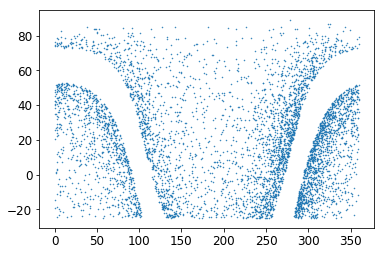

In [5]:
plt.plot(tycho['ra'], tycho['dec'], '.', ms=1);

In [6]:
gaia_path = '/global/cscratch1/sd/rongpu/dr9dev/gaia_in_dr9sv/brightest_g_less_than_19_stars-dr9sv_south.fits'
gaia_columns = ['RA', 'DEC', 'PHOT_G_MEAN_MAG', 'PHOT_BP_MEAN_MAG', 'PHOT_RP_MEAN_MAG']
gaia = fitsio.read(gaia_path, columns=gaia_columns)
gaia = Table(gaia)

Doubly matched objects = 0
Final matched objects = 195


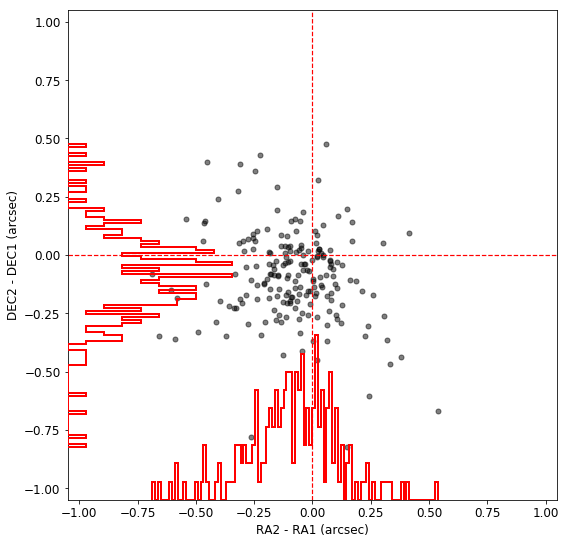

In [7]:
idx1, idx2, _, _, _ = match_coord(tycho['ra'], tycho['dec'], gaia['RA'], gaia['DEC'])

In [8]:
tycho = tycho[idx1]
gaia = gaia[idx2]

In [9]:
# Gaia-to-DECam transformations used in legacypipe
color = gaia['PHOT_BP_MEAN_MAG'] - gaia['PHOT_RP_MEAN_MAG']
bands = ['g', 'r', 'z']
for i, b in enumerate(bands):
    # Use Arjun's Gaia-to-DECam transformations.
    coeffs = dict(
        g=[-0.11368, 0.37504, 0.17344, -0.08107, 0.28088,
           -0.21250, 0.05773,-0.00525],
        r=[ 0.10533,-0.22975, 0.06257,-0.24142, 0.24441,
            -0.07248, 0.00676],
        z=[ 0.46744,-0.95143, 0.19729,-0.08810, 0.01566])[b]
    mag = np.copy(gaia['PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs):
        mag += c * color**order
    gaia['decam_'+b] = mag
# print(ls_mag)

In [23]:
gaia_plot = Table()
gaia_plot['BP_RP'] = np.linspace(-1, 6.2, 200)
bands = ['g', 'r', 'z']
for i, b in enumerate(bands):
    # Use Arjun's Gaia-to-DECam transformations.
    coeffs = dict(
        g=[-0.11368, 0.37504, 0.17344, -0.08107, 0.28088,
           -0.21250, 0.05773,-0.00525],
        r=[ 0.10533,-0.22975, 0.06257,-0.24142, 0.24441,
            -0.07248, 0.00676],
        z=[ 0.46744,-0.95143, 0.19729,-0.08810, 0.01566])[b]
    mag = np.zeros(len(gaia_plot))
    for order, c in enumerate(coeffs):
        mag += c * gaia_plot['BP_RP']**order
    gaia_plot['decam_'+b] = mag

In [11]:
# Get tractor photometry
sweep_list = ['sweep-180p010-190p015.fits', 'sweep-190p010-200p015.fits']
cat = []
for sweep_fn in sweep_list:
    tmp = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/'+sweep_fn, columns=['GAIA_PHOT_G_MEAN_MAG'])
    idx = np.where(tmp['GAIA_PHOT_G_MEAN_MAG']!=0)[0]
    tmp = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/'+sweep_fn, rows=idx)
    tmp = Table(tmp)
    cat.append(tmp)
cat = vstack(cat)
print(len(cat))
mask = cat['MASKBITS']==0
print(np.sum(mask))
cat = cat[mask]
mask = cat['TYPE']=='PSF '
print(np.sum(mask))
cat = cat[mask]
mask = cat['FRACFLUX_R']<0.1
print(np.sum(mask))
cat = cat[mask]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    cat['w1mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W1'])
    cat['w2mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W2'])

299634
256746
246825
242940


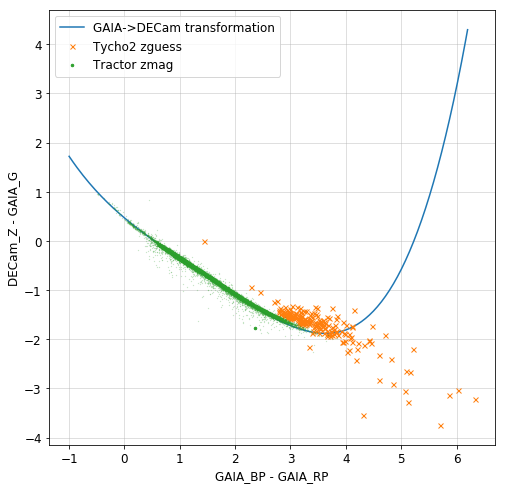

In [24]:
plt.figure(figsize=(8, 8))
plt.plot((gaia_plot['BP_RP']), (gaia_plot['decam_z']), '-', label='GAIA->DECam transformation')

mask = (gaia['PHOT_BP_MEAN_MAG']!=0) & (gaia['PHOT_RP_MEAN_MAG']!=0)
plt.plot((gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])[mask], (tycho['zguess']-gaia['PHOT_G_MEAN_MAG'])[mask], 'x', ms=5, label='Tycho2 zguess')

mask = (cat['GAIA_PHOT_G_MEAN_MAG']>7) & (cat['GAIA_PHOT_G_MEAN_MAG']<18)
mask &= np.isfinite(cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[0], (cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[0], 'C2.', ms=5, label='Tractor zmag')
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.4, alpha=0.5,  label='_nolegend_')

plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECam_Z - GAIA_G')
# plt.axis([-0.5, 3.5, -0.5, 1])
plt.grid(alpha=0.5)
plt.legend()
plt.show()

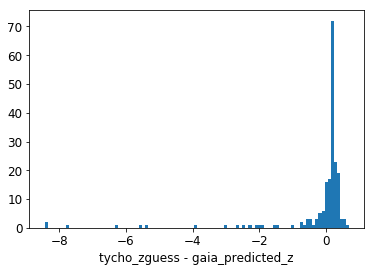

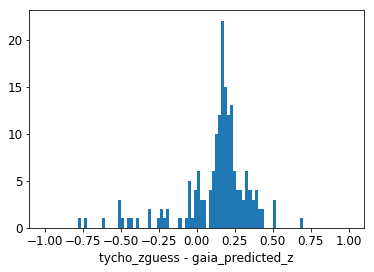

In [13]:
plt.hist(tycho['zguess'] - gaia['decam_z'], 100)
plt.xlabel('tycho_zguess - gaia_predicted_z')
plt.show()

plt.hist(tycho['zguess'] - gaia['decam_z'], 100, range=(-1, 1))
plt.xlabel('tycho_zguess - gaia_predicted_z')
plt.show()

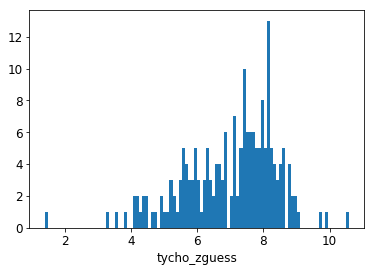

In [27]:
plt.hist(tycho['zguess'], 100)
plt.xlabel('tycho_zguess')
plt.show()

3


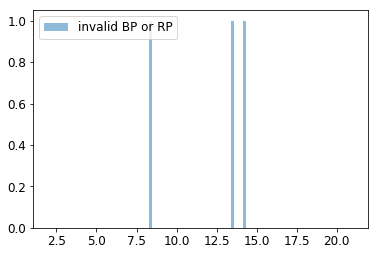

In [31]:
mask = (gaia['PHOT_BP_MEAN_MAG']==0) | (gaia['PHOT_RP_MEAN_MAG']==0)
print(np.sum(mask))
plt.hist(gaia['PHOT_G_MEAN_MAG'][mask], 100, alpha=0.5, range=(2, 21), label='invalid BP or RP')
plt.legend()
plt.show()